In [ ]:
import numpy as np
import pandas as pd

In [ ]:
sent_df = pd.read_csv("/content/drive/MyDrive/ds_Onome_Joseph/fear_greed_index.csv")
trad_df = pd.read_csv("/content/drive/MyDrive/ds_Onome_Joseph/historical_data.csv")

In [ ]:
sent_df.head(5)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
trad_df.head(5)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2/12/2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2/12/2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2/12/2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2/12/2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2/12/2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Data Preprocessing and Cleaning

In [ ]:
# --- Trader Data ---
col = next((c for c in trad_df.columns if 'time' in c.lower()), None)
if col:
    trad_df['date'] = pd.to_datetime(trad_df[col], errors='coerce').dt.date

col = next((c for c in trad_df.columns if 'account' in c.lower()), None)
if col:
    trad_df['account'] = trad_df[col]

col = next((c for c in trad_df.columns if 'pnl' in c.lower() or 'profit' in c.lower()), None)
if col:
    trad_df['closedPnL'] = trad_df[col]

col = next((c for c in trad_df.columns if 'price' in c.lower()), None)
if col:
    trad_df['execution_price'] = trad_df[col]

col = next((c for c in trad_df.columns if 'size' in c.lower() and 'usd' not in c.lower()), None)
if col:
    trad_df['size'] = trad_df[col]

trad_df['profitable_trade'] = trad_df['closedPnL'] > 0
trad_df['trade_value'] = abs(trad_df['execution_price'] * trad_df['size'])
trad_df['leverage'] = next((trad_df[c] for c in trad_df.columns if 'leverage' in c.lower()), 1.0)


In [ ]:
# --- Sentiment Data ---
col = next((c for c in sent_df.columns if 'date' in c.lower()), None)
if col:
    sent_df['date'] = pd.to_datetime(sent_df[col], errors='coerce').dt.date

col = next((c for c in sent_df.columns if 'classification' in c.lower() or 'sentiment' in c.lower()), None)
if col:
    sent_df['Classification'] = sent_df[col]

# --- Clean Data ---
trader_data_clean = trad_df.dropna(subset=['date', 'closedPnL', 'account']).copy()
sentiment_data_clean = sent_df.dropna(subset=['date', 'Classification']).copy()


In [ ]:
# Create daily trader statistics
daily_trader_stats = trader_data_clean.groupby(['date', 'account']).agg({
    'closedPnL': ['sum', 'count', 'mean'],
    'profitable_trade': 'mean',
    'trade_value': 'sum',
    'leverage': 'mean'
}).reset_index()

# Flatten column names
daily_trader_stats.columns = [
    'date', 'account', 'total_pnl', 'num_trades',
    'avg_pnl', 'win_rate', 'total_volume', 'avg_leverage'
]

# Merge with sentiment data
merged_data = daily_trader_stats.merge(
    sentiment_data_clean[['date', 'Classification']],
    on='date',
    how='inner'
)

# Sentiment distribution
sentiment_counts = merged_data['Classification'].value_counts()

# Basic statistics
total_pnl_sum = merged_data['total_pnl'].sum()
avg_daily_pnl = merged_data['total_pnl'].mean()
avg_win_rate = merged_data['win_rate'].mean()
total_volume_sum = merged_data['total_volume'].sum()


In [ ]:
merged_data.tail()

,date,account,total_pnl,num_trades,avg_pnl,win_rate,total_volume,avg_leverage,Classification
525,2025-05-02,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,1843.301845,327,5.637009,0.385321,7.677450e+05,1.0,Greed
526,2025-05-02,0x8477e447846c758f5a675856001ea72298fd9cb5,554.257954,20,27.712898,0.600000,1.109920e+04,1.0,Greed
527,2025-05-02,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,-6194.283149,368,-16.832291,0.122283,1.531596e+06,1.0,Greed
528,2025-05-02,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14644.100674,218,67.174774,0.422018,5.144274e+05,1.0,Greed
529,2025-05-02,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,713.828090,14,50.987721,0.785714,5.136341e+04,1.0,Greed


In [ ]:
merged_data.to_csv("merged_data.csv", index=False)  # index=False removes the row numbers

##Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

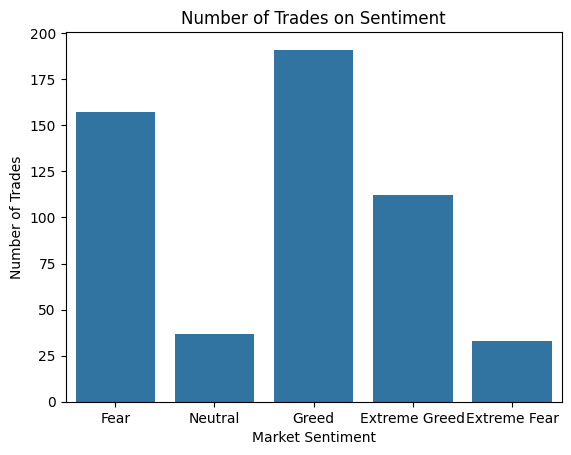

In [ ]:
sns.countplot(data=merged_data, x='Classification')
plt.title("Number of Trades on Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.show()

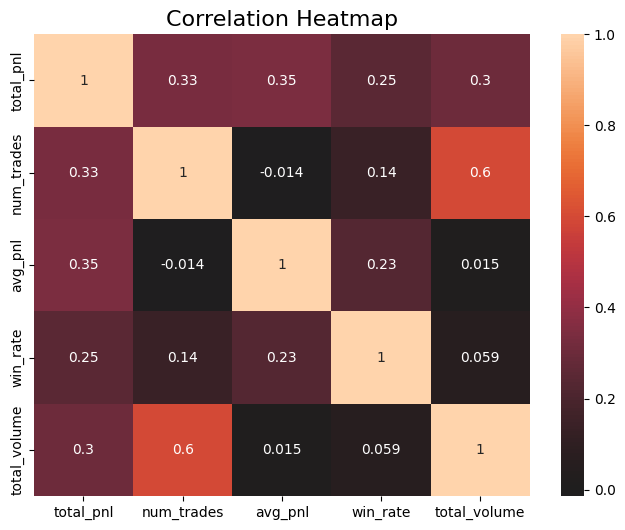

In [ ]:
corr_matrix = merged_data[['total_pnl','num_trades','avg_pnl','win_rate', 'total_volume']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, center=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

/tmp/ipython-input-3405471317.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x='Classification', y='avg_trade_value_1', palette='Blues', ax=axes[0])
/tmp/ipython-input-3405471317.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x='Classification', y='avg_trade_value_2', palette='Greens', ax=axes[1])
/tmp/ipython-input-3405471317.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x='Classification', y='avg_trade_value_3', palette='Oranges', ax=axes[2])


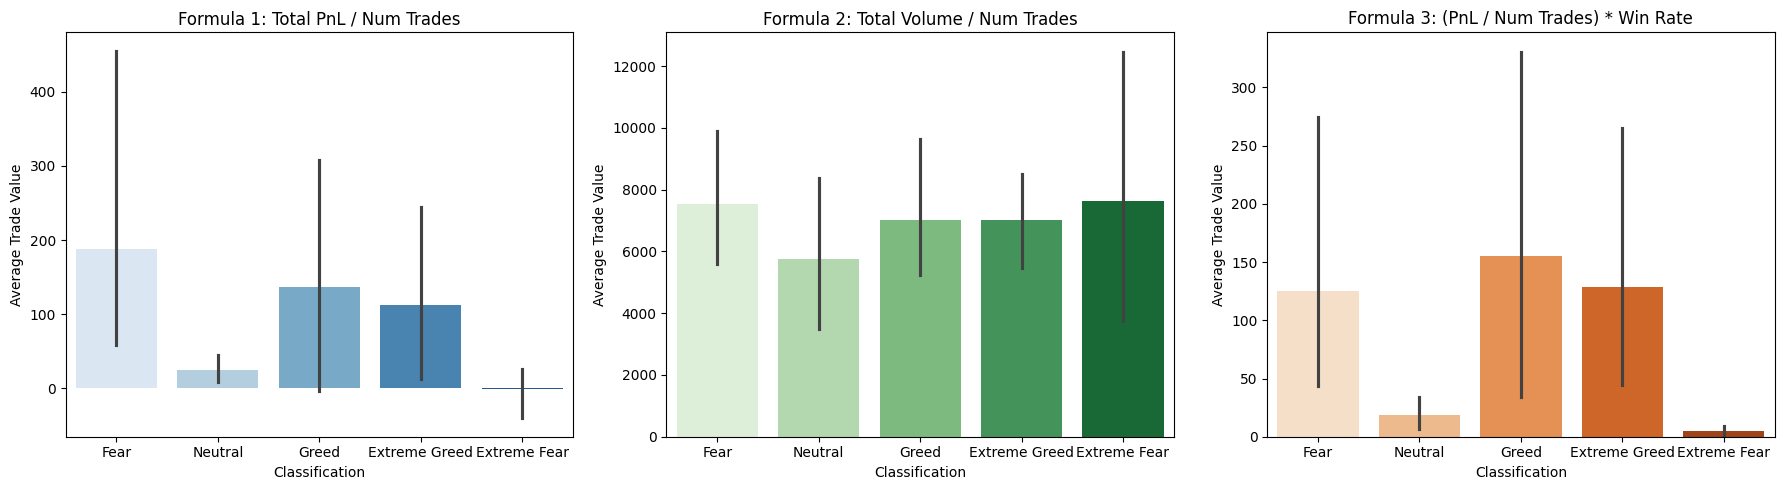

In [ ]:
merged_data['avg_trade_value_1'] = merged_data['total_pnl'] / merged_data['num_trades']  # Formula 1
merged_data['avg_trade_value_2'] = merged_data['total_volume'] / merged_data['num_trades']  # Formula 2
merged_data['avg_trade_value_3'] = (merged_data['total_pnl'] / merged_data['num_trades']) * merged_data['win_rate']  # Formula 3

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot each formula separately
sns.barplot(data=merged_data, x='Classification', y='avg_trade_value_1', palette='Blues', ax=axes[0])
axes[0].set_title('Formula 1: Total PnL / Num Trades')
axes[0].set_ylabel('Average Trade Value')

sns.barplot(data=merged_data, x='Classification', y='avg_trade_value_2', palette='Greens', ax=axes[1])
axes[1].set_title('Formula 2: Total Volume / Num Trades')
axes[1].set_ylabel('Average Trade Value')

sns.barplot(data=merged_data, x='Classification', y='avg_trade_value_3', palette='Oranges', ax=axes[2])
axes[2].set_title('Formula 3: (PnL / Num Trades) * Win Rate')
axes[2].set_ylabel('Average Trade Value')

plt.tight_layout()
plt.show()

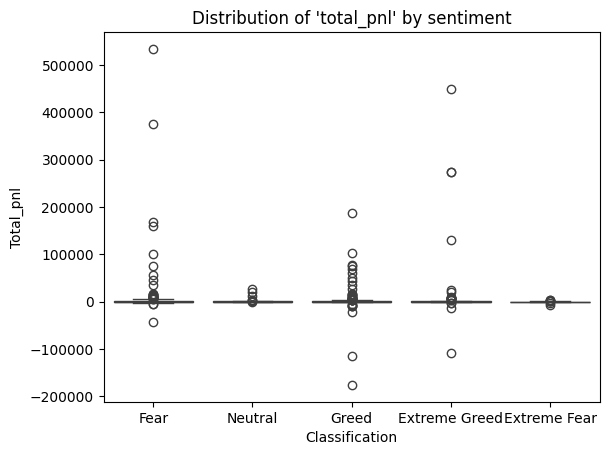

In [ ]:
sns.boxplot(data=merged_data, x='Classification', y='total_pnl')
plt.title("Distribution of 'total_pnl' by sentiment")
plt.ylabel('Total_pnl')

plt.show()

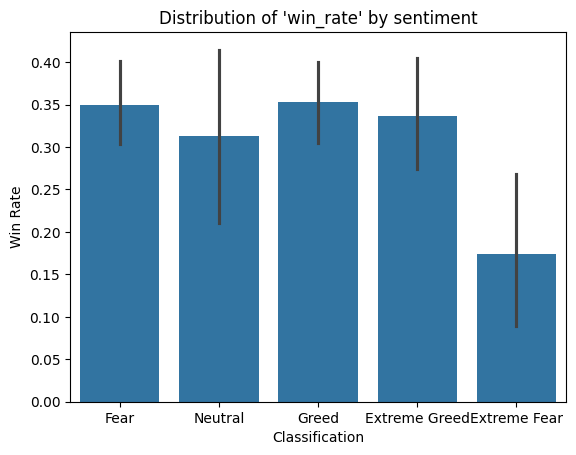

In [ ]:
sns.barplot(data=merged_data, x='Classification', y='win_rate')
plt.title("Distribution of 'win_rate' by sentiment")
plt.ylabel('Win Rate')

plt.show()

/tmp/ipython-input-1024241270.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trader_segments.groupby(['pnl_quartile', 'Classification'])['win_rate'].mean().unstack().plot(kind='bar', title='Win Rate by Segment & Sentiment')


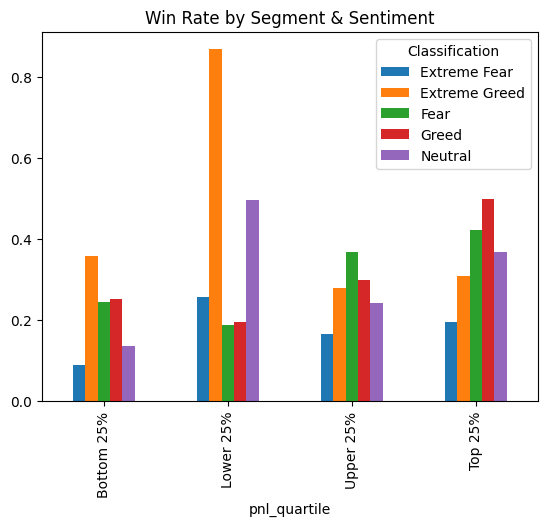

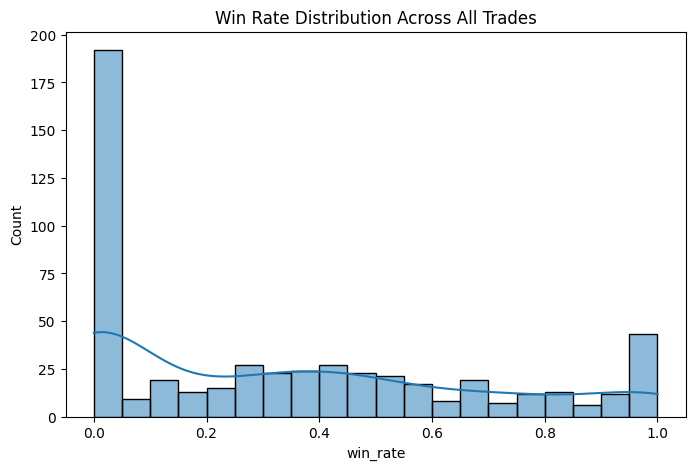

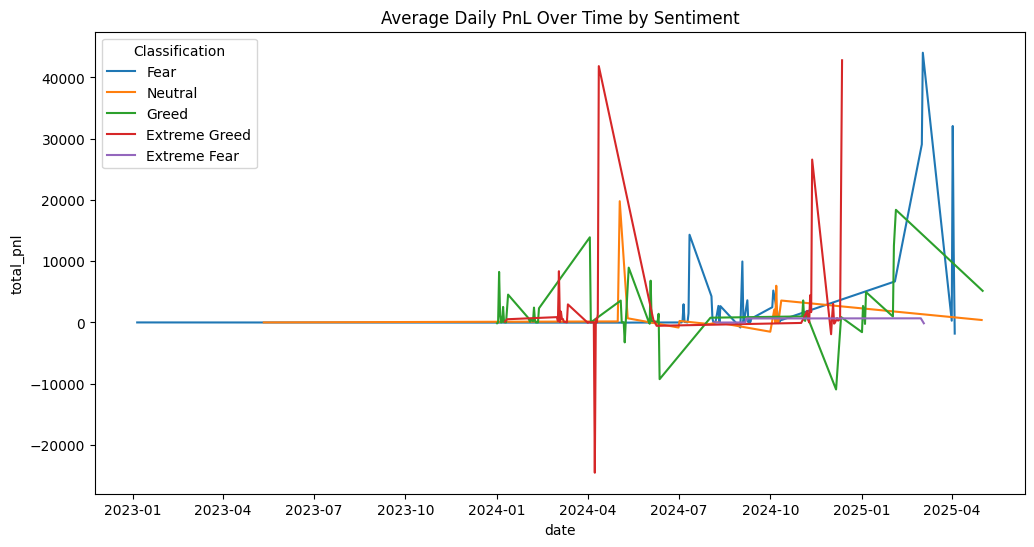

In [ ]:
# Top & Bottom Performers
top_perf = merged_data.nlargest(10, 'total_pnl')[['account', 'total_pnl', 'win_rate', 'Classification', 'date']]
bottom_perf = merged_data.nsmallest(10, 'total_pnl')[['account', 'total_pnl', 'win_rate', 'Classification', 'date']]

# Trader-level Aggregations
trader_metrics = merged_data.groupby('account').agg({
    'total_pnl': 'sum',
    'win_rate': 'mean',
    'total_volume': 'sum',
    'num_trades': 'sum',
    'avg_leverage': 'mean'
}).reset_index()

trader_metrics.columns = ['account', 'cumulative_pnl', 'avg_win_rate', 'total_volume', 'total_trades', 'avg_leverage']
trader_metrics['pnl_quartile'] = pd.qcut(trader_metrics['cumulative_pnl'], 4, labels=['Bottom 25%', 'Lower 25%', 'Upper 25%', 'Top 25%'])
trader_metrics['volume_quartile'] = pd.qcut(trader_metrics['total_volume'], 4, labels=['Low Vol', 'Med Vol', 'High Vol', 'Very High Vol'])

# Merge Segments Back
trader_segments = merged_data.merge(trader_metrics[['account', 'pnl_quartile']], on='account')

trader_segments.groupby(['pnl_quartile', 'Classification'])['win_rate'].mean().unstack().plot(kind='bar', title='Win Rate by Segment & Sentiment')
plt.show()

# Win Rate Distribution
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['win_rate'], bins=20, kde=True)
plt.title('Win Rate Distribution Across All Trades')
plt.show()

# PnL Over Time by Sentiment
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_data.groupby(['date', 'Classification'])['total_pnl'].mean().reset_index(),
             x='date', y='total_pnl', hue='Classification')
plt.title('Average Daily PnL Over Time by Sentiment')
plt.show()
